In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
%pylab inline
import tensorflow as tf
import numpy as np
import healpy as hp
import scipy.special as ss
import math
import sys
import tqdm

Populating the interactive namespace from numpy and matplotlib


/Users/charnock/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Global properties

In [3]:
ℓ_max = 47
nside_in = 16
n_pix_in = hp.nside2npix(nside_in)
nside_out = 8
n_pix_out = hp.nside2npix(nside_out)
_FLOATX = tf.complex128

# Convolution transforms on the surface of a sphere

We can easily compute the convolution of a kernel with the surface of a sphere using (https://arxiv.org/pdf/astro-ph/0008227.pdf) eq. 8
$$T_{mm'm''}=\sum_\ell s_{\ell m} d^\ell_{mm'}(\theta_{\sf E})d^\ell_{m'm''}(\theta)k^*_{\ell m''}$$
where $s_{\ell m}$ and $k_{\ell m}$ are the surface of the sphere and the convolutional kernel in a spherical harmonic basis and $\theta_{\sf E}$ and $\theta$ are the polar angle to the centre of the kernel away from the north pole and the size of the kernel. To get the convolved sky at all possible orientations of $\omega$ on an equidistant coordinate grid in $\phi=[0, \pi)$ (corresponding to the polar angle of the convolution) and $\phi_{\sf E}=[0, 2\pi)$ (corresponding to the azimuthal angle of the convolution) we can safely set $\theta=\theta_{\sf E}=\pi/2$ leaving us with
$$T(\phi,\phi_{\sf E}, \omega) = \sum_{mm'm''}T_{mm'm''}e^{im\phi_{\sf E}+im'\phi+im''\omega}$$
$\omega$ can be set to some value which fixes the tilt of the scanning path which is not important for us as long as we consider it remains fixed.

We need to calculate the Wigner-$d$ functions which are defined in relation to the Wigner-$D$ matrix (which is an irreducible representation of SU(2) and SO(3))) as
$$D^\ell_{mm'}(\phi_2,\theta,\phi_1)=e^{-im\phi_2}d^\ell_{mm'}(\theta)e^{-im'\phi_1}.$$
 

The recursion relation for the Wigner-$d$ function begins with 
$$g_{00}=1$$
and
$$g_{\ell0}=\sqrt{\frac{2\ell-1}{2\ell}}g_{\ell-1~0}$$
when $\ell>0$ and
$$g_{\ell m}=\sqrt{\frac{\ell-m+1}{\ell+m}}g_{\ell m-1}$$
when $\ell>0$ and $0<m\le\ell$. These are used to calculate
$$d^\ell_{m\ell} = (-1)^{\ell+m}g_{\ell m}(1+\cos(\theta))^m(\sin(\theta))^{\ell-m}$$
from which all the other Wigner-$d$ functions come from
$$d_{mm'-1}^\ell=\sqrt{\frac{\ell(\ell+1)-m(m+1)}{\ell(\ell+1)-m'(m'-1)}}d_{m+1~m'}^\ell+\frac{m+m'}{\sqrt{\ell(\ell+1)-m'(m'-1)}}\frac{\sin(\theta)}{1+\cos(\theta)}d_{mm'}^\ell$$
where $\cos(\theta)\ge0$, $\ell>0$, $0\le m<\ell$ and $-\ell<m'\le\ell$,
$$d_{\ell m'-1}^\ell=\frac{\ell+m'}{\sqrt{\ell(\ell+1)-m'(m'-1)}}\frac{\sin(\theta)}{1+\cos(\theta)}d^\ell_{\ell m'}$$
where $\cos(\theta)\ge0$, $\ell>0$ and $-\ell<m'\le\ell$ and
$$d_{mm'}^\ell=(-1)^{m+m'}d^\ell_{-m~-m'}$$
when $\ell>0$, $-\ell\le m<0$ and $-\ell\le m'\le\ell$.
<!--$$d^\ell_{0m}=\left\{\begin{array}{rl}\sqrt{\frac{(\ell+m)!}{(\ell-m)!}}P_{\ell~-m}&\ell>0,~ -\ell\le m<0\\P_{\ell0}&\ell>0,~m=0\\(-1)^m\sqrt{\frac{(\ell-m)!}{(\ell+m)!}}P_{\ell m}&\ell>0,~ 0<m\le\ell\end{array}\right.$$
where $P_{\ell m}$ are the associated Legrendre polynomials (https://pdfs.semanticscholar.org/d7d5/8956b96a49195d90fb77795c8f7ebff30446.pdf). The rest of the recusion relation for the Wigner-$d$ functions are 
$$d^\ell_{m+1~m'}=\sqrt{\frac{\ell(\ell+1)-m'(m'-1)}{\ell(\ell+1)-m(m+1)}}d^\ell_{mm'-1}-\frac{(m+m')}{\sqrt{\ell(\ell+1)-m(m+1)}}\frac{\sin(\theta)}{1+\cos(\theta)}d^\ell_{mm'},$$
with $\cos(\theta)\ge0$, $\ell>0$, $0\le m<\ell$ and $-\ell<m'\le \ell$,
$$d^\ell_{m+1~-\ell}=\frac{(\ell-m)}{\sqrt{\ell(\ell+1)-m(m+1)}}\frac{\sin(\theta)}{(1+\cos(\theta))}d^\ell_{m~-\ell}$$
with $\cos(\theta)\ge0$, $\ell>0$ and $0\le m < \ell$ and
$$d^\ell_{mm'}=(-1)^{m+m'}d^\ell_{-m~-m'}$$
with $\ell>0$, $-\ell\le m<0$ and $-\ell\le m'\le\ell$. This recurrence relation breaks down at high moments, but we're probably not in that situation here.-->

For generic values of $\theta$ the recurrence relations can be written as
$$d^\ell_{mm'}(\theta)=\left\{\begin{array}{lr}\delta_{mm'}&\theta=0\\(-1)^{\ell+m'}d^\ell_{-mm'}(\pi-\theta)=(-1)^{\ell+m}d^\ell_{m~-m'}(\pi-\theta)&\frac{\pi}{2}<\theta<\pi\\(-1)^{\ell+m'}\delta_{-mm'}=(-1)^{\ell+m'}\delta_{m~-m'}&\theta=\pi\\(-1)^{\ell+m'}d_{m~-m'}^\ell(\theta-\pi)=(-1)^{\ell+m}d_{-mm'}^\ell(\theta-\pi)&\pi<\theta<\frac{3\pi}{2}\\(-1)^{m+m'}d^\ell_{mm'}(2\pi-\theta)&\frac{3\pi}{2}\le\theta<2\pi\end{array}\right.$$

Once the Wigner-$d$ functions are calculated we can put them into a TensorFlow tensor for use later.

In [4]:
def g(ℓ, m):
    if ℓ == 0 and m == 0:
        return 1
    elif ℓ > 0 and m == 0:
        return np.sqrt((2 * ℓ - 1) / (2 * ℓ)) * g(ℓ - 1, m)
    elif ℓ > 0 and m > 0 and m <= ℓ:
        return np.sqrt((ℓ - m + 1) / (ℓ + m)) * g(ℓ, m - 1)
    else:
        print("g -> ℓ = " + str(ℓ) + ", m = " + str(m))
        sys.exit()

def d_ℓmℓ(ℓ, m, θ):
    return (-1.)**(ℓ + m) * g(ℓ, m) * (1. + np.cos(θ))**m * np.sin(θ)**(ℓ - m)

def d_ℓmmpm1(ℓ, m, mp, θ, d_arr, ℓ_max):
    return np.sqrt((ℓ * (ℓ + 1.) - m * (m + 1)) / (ℓ * (ℓ + 1.) - mp * (mp - 1))) * d_arr[ℓ, m + 1 + ℓ_max, mp + ℓ_max] + (m + mp) / np.sqrt(ℓ * (ℓ + 1.) - mp * (mp - 1.)) * np.sin(θ) / (1. + np.cos(θ)) * d_arr[ℓ, m + ℓ_max, mp + ℓ_max]

def d_ℓℓmpm1(ℓ, mp, θ, d_arr, ℓ_max):
    return (ℓ + mp) / np.sqrt(ℓ * (ℓ + 1.) - mp * (mp - 1.)) * np.sin(θ) / (1. + np.cos(θ)) * d_arr[ℓ, ℓ + ℓ_max, mp + ℓ_max]
    
def d_ℓmmmmp(ℓ, m, mp, d_arr, ℓ_max):
    return (-1.)**(m + mp) * d_arr[ℓ, - m + ℓ_max, - mp + ℓ_max]

In [5]:
θ = np.pi / 2. # θE = np.pi / 2.
ϕ_in, ϕE_in = hp.pix2ang(nside_in, np.arange(n_pix_in))
ϕ_out, ϕE_out = hp.pix2ang(nside_out, np.arange(n_pix_out))
ω = 0.

-0.7071067811865476 1.0


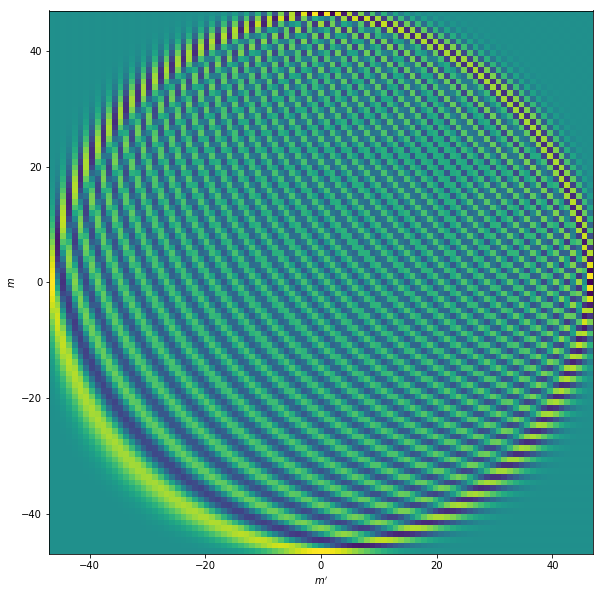

In [6]:
d_arr = np.zeros((ℓ_max + 1, 2 * ℓ_max + 1, 2 * ℓ_max + 1))
for ℓ in range(ℓ_max, -1, -1):
    for m in range(ℓ, -ℓ - 1, -1):
        for mp in range(ℓ, -ℓ - 1, -1):
            if m >= 0:
                if mp == ℓ:
                    d_arr[ℓ, m + ℓ_max, mp + ℓ_max] = d_ℓmℓ(ℓ, m, θ)
                if m == ℓ and mp > -ℓ:
                    d_arr[ℓ, m + ℓ_max, mp - 1 + ℓ_max] = d_ℓℓmpm1(ℓ, mp, θ, d_arr, ℓ_max)
                if m < ℓ and mp > -ℓ:
                    d_arr[ℓ, m + ℓ_max, mp - 1 + ℓ_max] = d_ℓmmpm1(ℓ, m, mp, θ, d_arr, ℓ_max)
            if m < 0:
                d_arr[ℓ, m + ℓ_max, mp + ℓ_max] = d_ℓmmmmp(ℓ, m, mp, d_arr, ℓ_max)  
d = tf.constant(d_arr, dtype = _FLOATX)
print(np.min(d_arr), np.max(d_arr))
figure(figsize = (10, 10))
imshow(d_arr[ℓ_max], extent = [-ℓ_max, ℓ_max, -ℓ_max, ℓ_max])
xlabel("$m'$")
ylabel("$m$")

# Sphere and kernel tensors

We need to define the placeholder for the surface of the sphere and also design a function to build the weight kernel in real space. The surface of the sphere is a 1D `healpix` pixel array.

## Weight kernel

The weight kernel, $k$, needs to be defined in real space before being transformed into spherical harmonic space. To do this we first decide (arbitrarily) on a central pixel index and then use `healpy` to get the surrounding contiguously connected pixel indices. 

We create a set of weight variables in their own scope and place these weights in the `healpy` pixel array which can then be transformed in TensorFlow.

In [7]:
def spherical_weight_kernel(indices, name, n_pix, input_filters, output_filters):
    with tf.variable_scope(name):
        w = tf.get_variable(name, shape = [indices.get_shape().as_list()[0], input_filters, output_filters], initializer = tf.random_normal_initializer(0., 1.))
        #w = tf.ones((9, filters))
        #w = tf.scatter_nd([[0]], [1.], [9])
    k = tf.scatter_nd(indices, w, [n_pix, input_filters, output_filters])
    k = tf.cast(k, dtype = _FLOATX)
    return k

In [8]:
input_filters = 2
output_filters = 3
pixels = 7
s = tf.placeholder(dtype = _FLOATX, shape = (None, n_pix_in, input_filters))
indices = tf.placeholder(dtype = tf.int32, shape = (pixels ** 2, 1))
k = spherical_weight_kernel(indices, 'w', n_pix_in, input_filters, output_filters)
ϕ_kernel = tf.placeholder(dtype = _FLOATX, shape = ())
ϕE_kernel = tf.placeholder(dtype = _FLOATX, shape = ())
iωmpp = tf.exp(tf.cast(tf.complex(0., 1.), dtype = _FLOATX) * tf.cast(np.arange(-ℓ_max, ℓ_max + 1), dtype = _FLOATX) * tf.constant(ω, dtype = _FLOATX))
iϕmp = tf.exp(tf.cast(tf.complex(0., 1.), dtype = _FLOATX) * tf.cast(np.arange(-ℓ_max, ℓ_max + 1), dtype = _FLOATX) * (tf.constant(ϕ_out, dtype = _FLOATX) + ϕ_kernel)[:, None])
iϕEm = tf.exp(tf.cast(tf.complex(0., 1.), dtype = _FLOATX) * tf.cast(np.arange(-ℓ_max, ℓ_max + 1), dtype = _FLOATX) * (tf.constant(ϕE_out, dtype = _FLOATX) + ϕE_kernel)[:, None])

# Spherical harmonic transform

Since equation (1) in the first comment cell works with the spherical harmonic transformation of the sky, $s$, and the kernel, $k$, we need to define the spherical transform in TensorFlow. In particular we are going to define the spherical harmonic transform to work on `healpix` pixel arrays.

The pixelised spherical harmonic transform is 
$$\gamma_{\ell m} = \frac{4\pi}{n_{\sf pix}}\sum_i\gamma(\theta_i, \phi_i)Y^\ell_m(\theta_i, \phi_i)$$
where the sum is over the pixels at all angles on the sky and $Y^\ell_m(\theta, \phi)$ are the spherical harmonic functions.

The inverse transform is
    $$\gamma(\theta, \phi) = \sum_\ell\sum_m\gamma_{\ell m}Y^{\ell*}_m(\theta, \phi).$$

We can precompute the spherical harmonic functions on the pixelised grid and create a $\ell$-length tensor in Tensorflow.

In [9]:
Yℓm_arr = np.zeros((n_pix_in, ℓ_max + 1, 2 * ℓ_max + 1))
for ℓ in range(ℓ_max + 1):
    if ℓ == 0:
        Yℓm_arr[:, 0, ℓ_max] = ss.sph_harm(0, 0, ϕE_in, ϕ_in)
    if ℓ > 0:
        for m in range(ℓ, -ℓ - 1, -1):
            Yℓm_arr[:, ℓ, m + ℓ_max] = ss.sph_harm(m, ℓ, ϕE_in, ϕ_in)

Yℓm = tf.constant(Yℓm_arr, dtype = _FLOATX)
Yℓm_conj = tf.conj(Yℓm)

/Users/charnock/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from sys.path.
/Users/charnock/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/ipykernel_launcher.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  import sys


In [10]:
def spherical_transform(γ, Yℓm, n_pix, kernel = False):
    if kernel:
        γ = tf.transpose(γ, [1, 2, 0])
    else:
        γ = tf.transpose(γ, [0, 2, 1])
    transform = tf.reduce_sum(4. * np.pi / n_pix * γ[:, :, :, None, None] * Yℓm, axis = 2)
    if kernel:
        return tf.transpose(transform, [2, 3, 0, 1])
    else:
        return tf.transpose(transform, [0, 2, 3, 1])

In [11]:
def inverse_spherical_transform(γ, Yℓm_conj, kernel = False):
    if kernel:
        γ = tf.transpose(γ, [2, 3, 0, 1])
    else:
        γ = tf.transpose(γ, [0, 3, 1, 2])
    inverse_transform = tf.reduce_sum(γ[:, :, None, :, :] * Yℓm_conj, axis = [3, 4])
    if kernel:
        return tf.transpose(inverse_transform, [2, 0, 1])
    else:
        return tf.transpose(inverse_transform, [0, 2, 1])

In [12]:
s_ = spherical_transform(s, Yℓm, n_pix_in)
is_ = inverse_spherical_transform(s_, Yℓm_conj)
k_ = spherical_transform(k, Yℓm, n_pix_in, kernel = True)
ik_ = inverse_spherical_transform(k_, Yℓm_conj, kernel = True)

# Spherical convolution

Using all the pieces we have created, notedly `d` and the returned value from `spherical_transform(γ, Yℓm, ℓ_max, n_pix)` we can define the spherical convolution using equation (1) from the first comment cell.

In [28]:
Tmmpmpp = tf.einsum('ijklmn,jmno->iklmo', tf.einsum('ijklm,jln->ijklnm', tf.einsum('ijkl,jkm->ijkml', s_, d), d), k_)
Tmmp = tf.einsum('ijklm,l->ijkm', Tmmpmpp, iωmpp)
Tm = tf.einsum('ijkl,mk->imjl', Tmmp, iϕmp)
T = tf.einsum('ijkl,jk->ijl', Tm, iϕEm)

# Initialise the session

In [14]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

# Example 

Let's now start with a map, $s_{\sf map}$, with $C_\ell = \ell$ which we can generate with `healpy`. We can also find a set of indices of contiguous pixels anywhere on the sphere which we will use to define the convolution kernel.

## Test map

/Users/charnock/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/healpy/sphtfunc.py:295: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning)
/Users/charnock/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/healpy/projector.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  img[w] = mpix


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


/Users/charnock/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/healpy/sphtfunc.py:156: ComplexWarning: Casting complex values to real discards the imaginary part
  lmax = lmax, mmax = mmax, gal_cut = gal_cut)


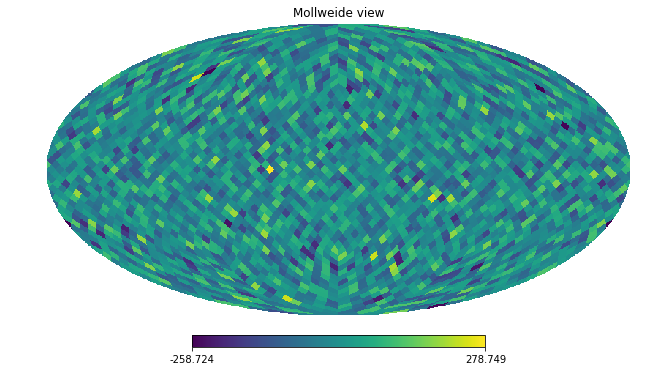

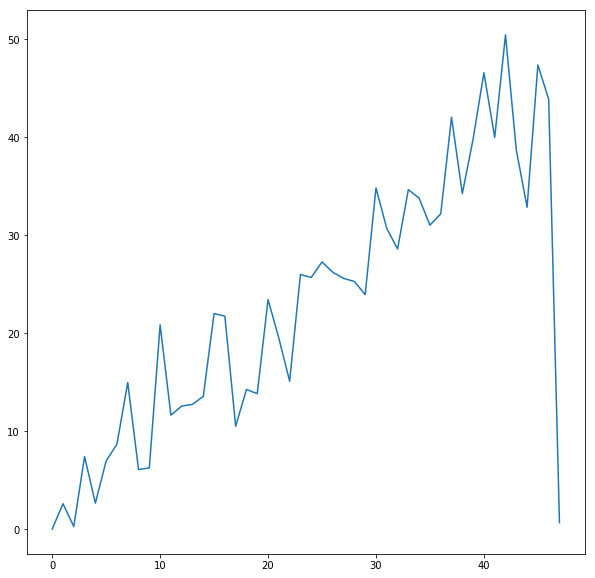

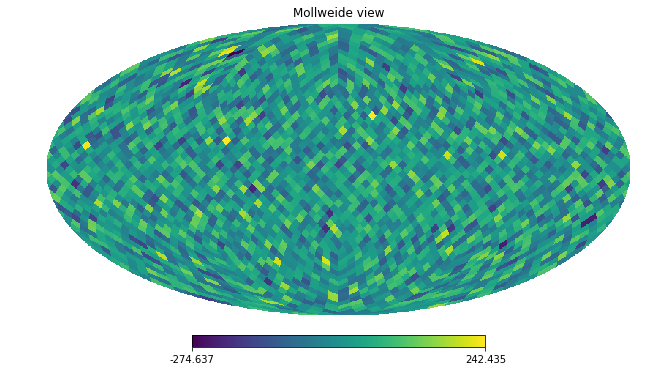

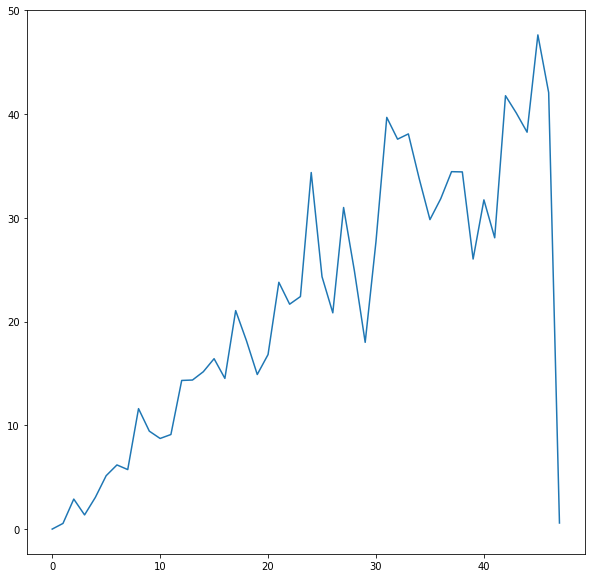

In [15]:
s_map = np.swapaxes(np.array([hp.synfast(np.arange(ℓ_max), nside_in), hp.synfast(np.arange(ℓ_max), nside_in)]), 0, 1)
test_map = sess.run(s, feed_dict = {s: [s_map]})[0]
for input_filter in range(input_filters):
    hp.mollview(test_map[:, input_filter])
    figure(figsize = (10, 10))
    plot(hp.anafast(test_map[:, input_filter]))

# Test weight kernel

In [16]:
central_index = hp.ang2pix(nside_in, np.pi / 2., np.pi / 2.)
ϕ_b, ϕE_b = hp.pix2ang(nside_in, central_index)

/Users/charnock/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/healpy/projector.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  img[w] = mpix


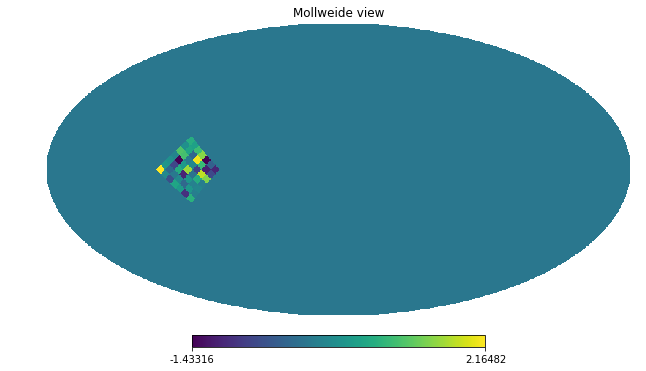

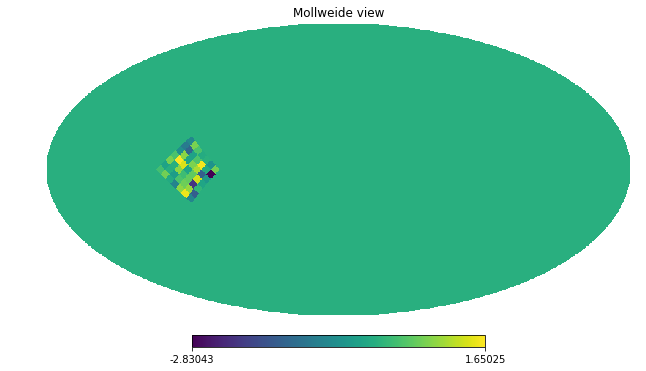

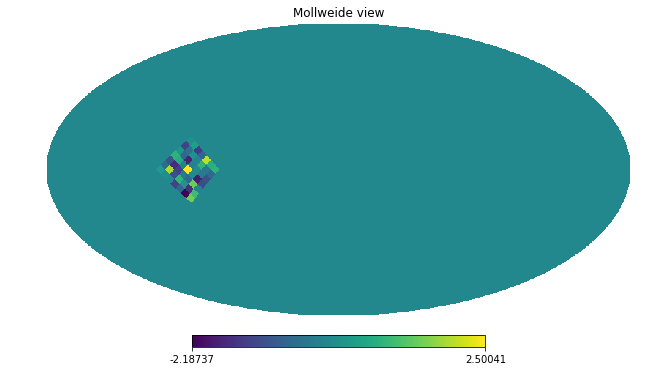

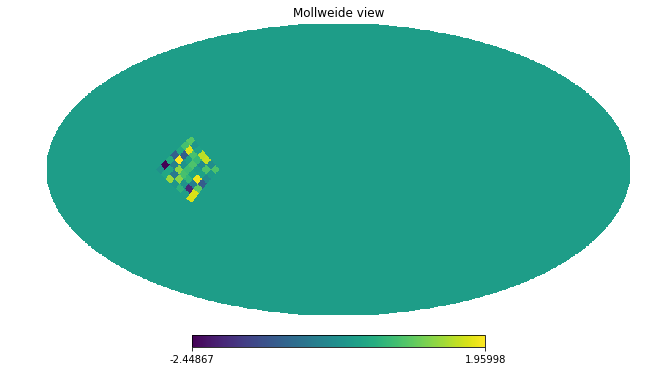

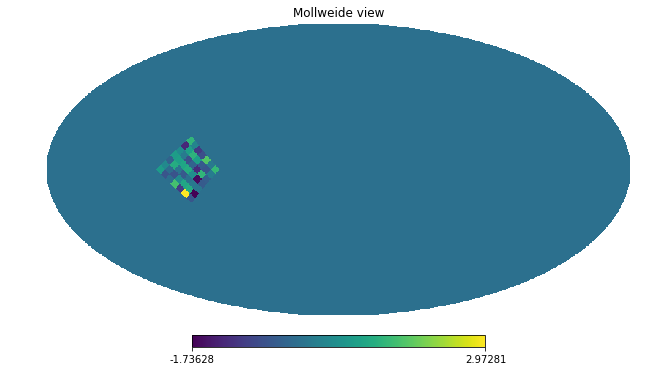

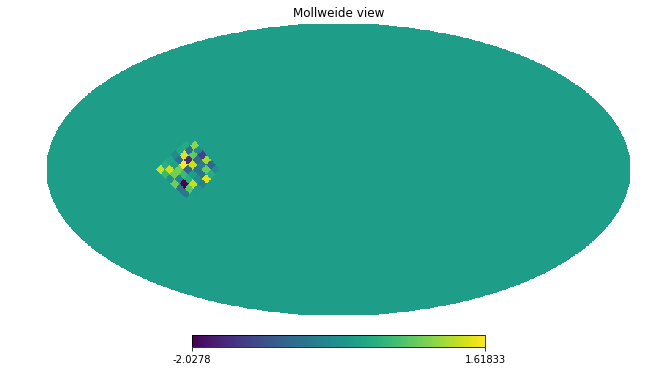

In [17]:
weight_indices = np.array([central_index])
if (pixels % 2 == 0):
    print('Number of pixels per side of the weight kernel needs to be odd')
else:
    if pixels > 1:
        initial_index = 0
        for pixel_count in range(3, pixels + 1, 2):
            final_index = weight_indices.shape[0]
            for pixel in range(initial_index, final_index):
                outer_indices = hp.get_all_neighbours(nside_in, weight_indices[pixel])
                weight_indices = np.append(weight_indices, outer_indices[np.where(np.in1d(outer_indices, weight_indices, invert = True))[0]])
            initial_index = final_index
    weight_indices = np.reshape(weight_indices, (pixels**2, 1))

test_k = sess.run(k, feed_dict = {indices: weight_indices})
for input_filter in range(input_filters):
    for output_filter in range(output_filters):
        hp.mollview(test_k[:, input_filter, output_filter])

# $a_{\ell m}$-space plots

We can have a look at what the spherical harmonic transforms of the sky and the kernel look like.

In [18]:
def plot_alm(γ, ℓ_max):
    aℓm = np.zeros((ℓ_max, ℓ_max, 2))
    Cℓ = np.sum(γ * np.conj(γ), axis = 1) / (2 * np.arange(ℓ_max + 1) + 1)
    
    for ℓ in range(ℓ_max):
        if ℓ > 0:
            aℓm[ℓ, :ℓ, 0] = np.real(γ[ℓ, -ℓ + ℓ_max: ℓ_max])
            aℓm[:ℓ, ℓ, 0] = np.real(γ[ℓ, ℓ_max + 1: ℓ_max + ℓ + 1])
            aℓm[ℓ, :ℓ, 1] = np.imag(γ[ℓ, -ℓ + ℓ_max: ℓ_max])
            aℓm[:ℓ, ℓ, 1] = np.imag(γ[ℓ, ℓ_max: ℓ_max + ℓ])
        aℓm[ℓ, ℓ, 0] = np.real(γ[ℓ, ℓ_max])
        aℓm[ℓ, ℓ, 1] = np.imag(γ[ℓ, ℓ_max])
            
    fig, ax = subplots(1, 3, figsize = (15, 5))
    subplots_adjust(wspace = 0.4)
    aℓm_real_plot = ax[0].imshow(aℓm[:, :, 0])
    colorbar(aℓm_real_plot, ax = ax[0], fraction=0.046, pad=0.04)
    aℓm_imag_plot = ax[1].imshow(aℓm[:, :, 1])
    colorbar(aℓm_imag_plot, ax = ax[1], fraction=0.046, pad=0.04)
    ax[2].plot(Cℓ)
    ax[2].set_xlabel("$\ell$")
    ax[2].set_ylabel("$C_\ell$")
    ax[2].set_xlim([0, ℓ_max - 1])
    ax[2].set_aspect('auto')

(-12.754945913608513+0j) (12.754945913608516+0j)


/Users/charnock/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(-14.375454537618921+0j) (14.375454537618923+0j)


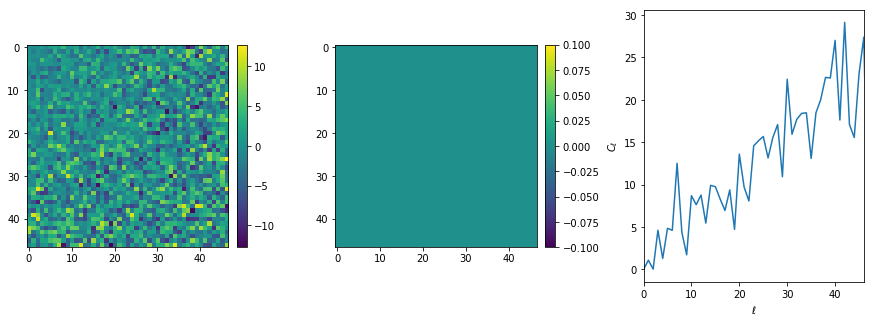

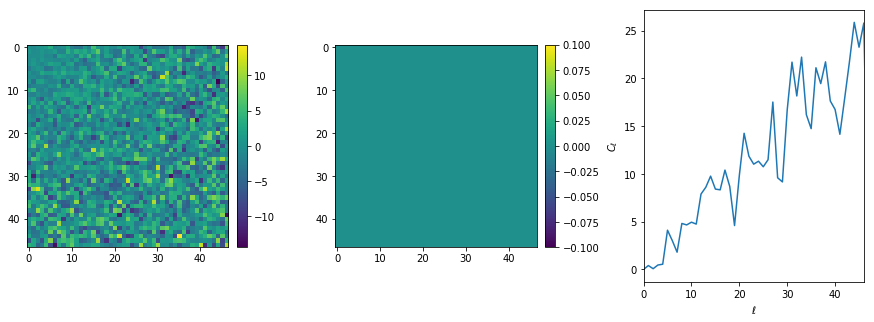

In [19]:
transformed_map = sess.run(s_, feed_dict = {s: [s_map]})[0]
for input_filter in range(input_filters):
    print(np.min(transformed_map[:, :, input_filter]), np.max(transformed_map[:, :, input_filter]))
    plot_alm(transformed_map[:, :, input_filter], ℓ_max)

(-265.40099368967435+0j) (167.92877526964008+0j)
(-190.94237461284354+0j) (167.54149025024367+0j)


/Users/charnock/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/healpy/projector.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  img[w] = mpix


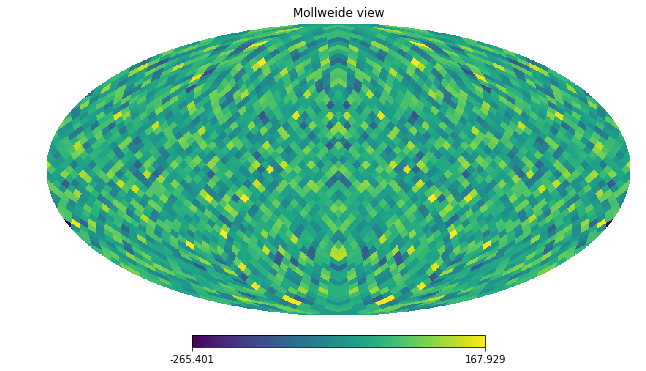

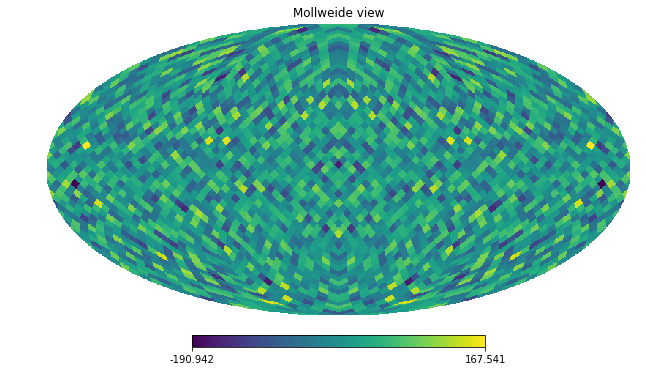

In [20]:
inverse_transformed_map = sess.run(is_, feed_dict = {s: [s_map]})[0]
for input_filter in range(input_filters):
    print(np.min(inverse_transformed_map[:, input_filter]), np.max(inverse_transformed_map[:, input_filter]))
    hp.mollview(inverse_transformed_map[:, input_filter])

(-0.02138605131637076+0j) (0.022037435238478304+0j)
(-0.024293354073317508+0j) (0.023137605488214315+0j)


/Users/charnock/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(-0.02313248079547597+0j) (0.02307912344258774+0j)
(-0.024012604242187537+0j) (0.023492408888988948+0j)
(-0.024285736214981375+0j) (0.02432277238953356+0j)
(-0.023221098121947236+0j) (0.023567567878595607+0j)


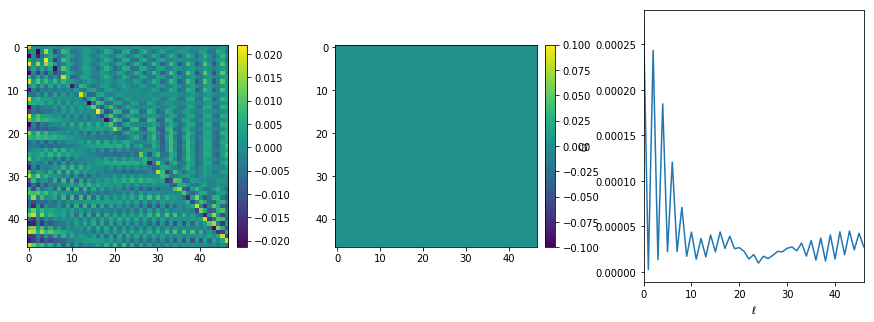

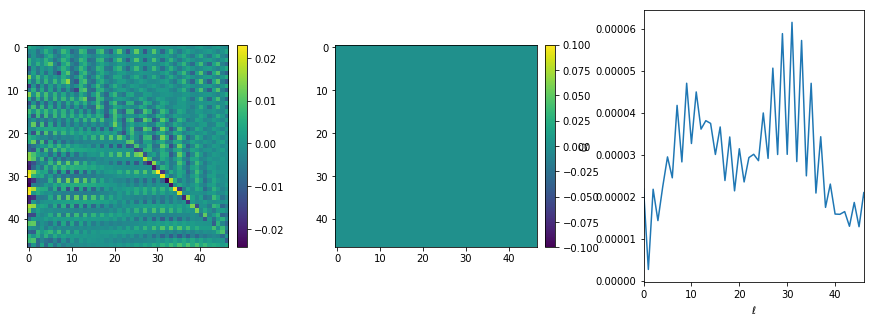

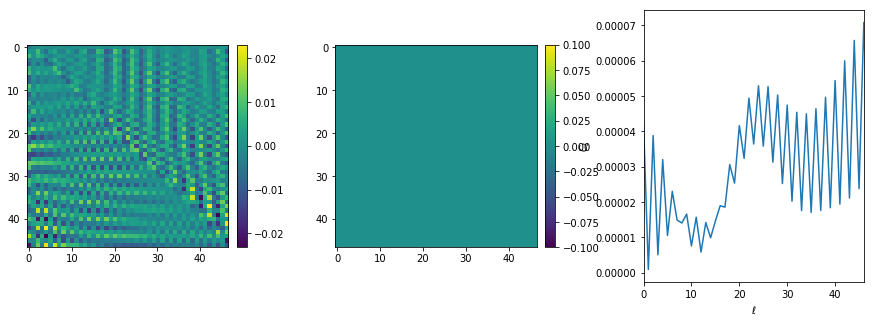

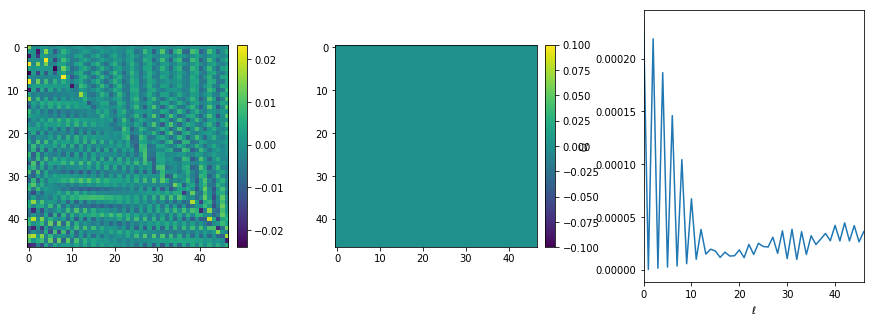

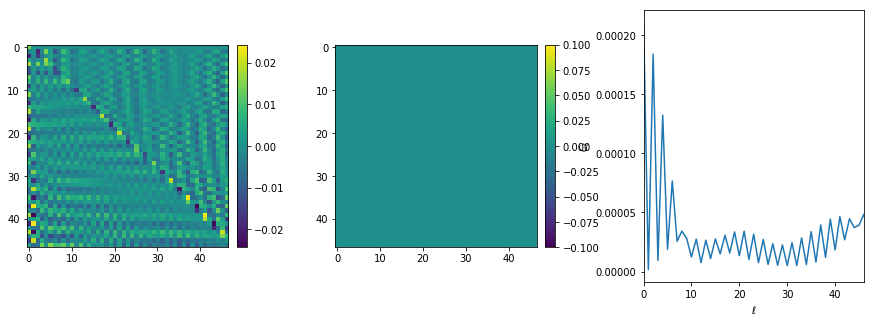

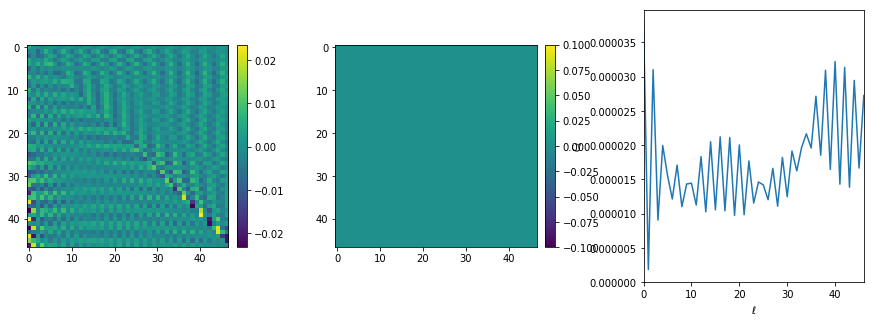

In [21]:
transformed_kernel = sess.run(k_, feed_dict = {indices: weight_indices})
for input_filter in range(input_filters):
    for output_filter in range(output_filters):
        print(np.min(transformed_kernel[:, :, input_filter, output_filter]), np.max(transformed_kernel[:, :, input_filter, output_filter]))
        plot_alm(transformed_kernel[:, :, input_filter, output_filter], ℓ_max) 

(-0.5624272135955041+0j) (0.9613804351492781+0j)
(-0.9444029608004523+0j) (0.8890240438766974+0j)


/Users/charnock/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/healpy/projector.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  img[w] = mpix


(-1.0551413088656325+0j) (0.8724231831669625+0j)
(-0.8669680506643982+0j) (0.8083264948057518+0j)
(-0.6315469610211841+0j) (1.0052785408107827+0j)
(-0.8441058826137899+0j) (0.7681139038199957+0j)


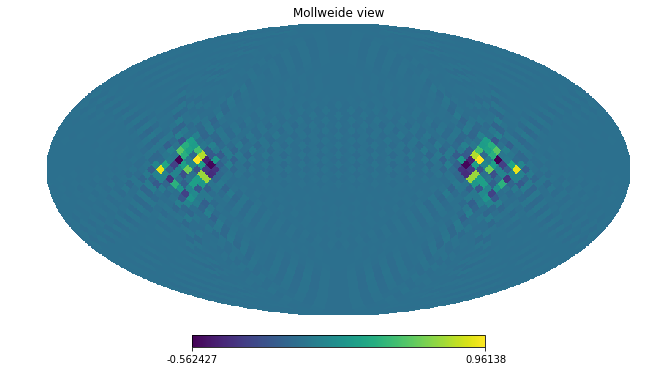

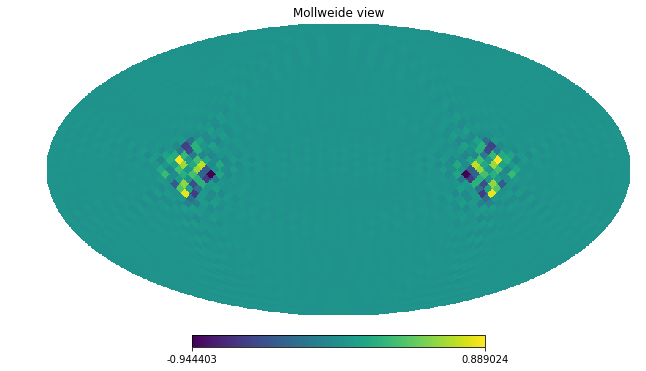

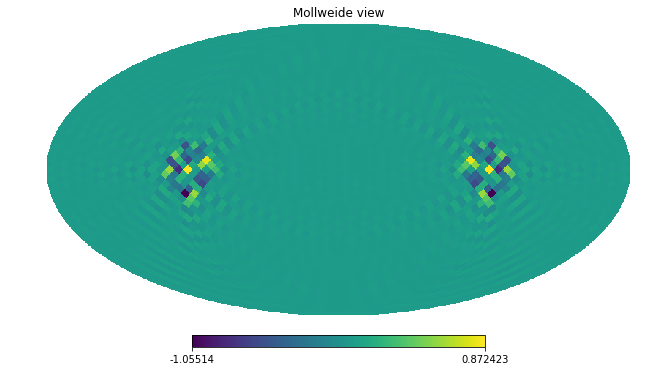

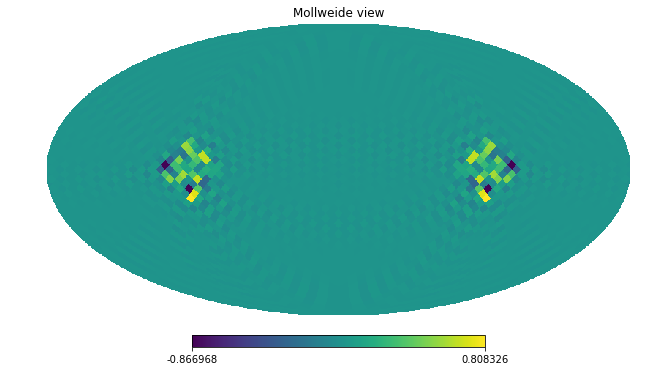

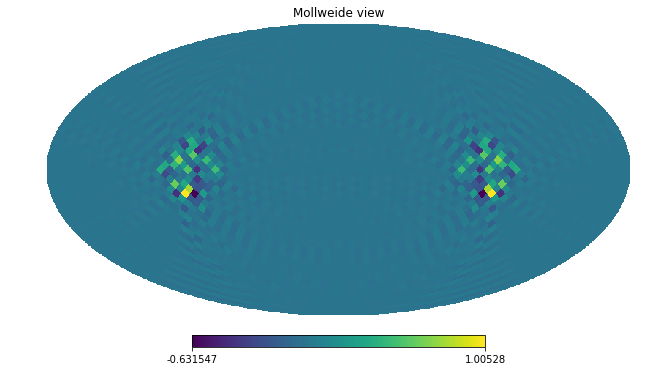

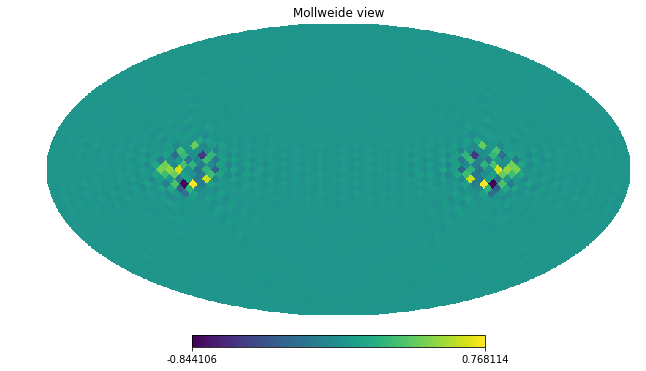

In [22]:
inverse_transformed_kernel = sess.run(ik_, feed_dict = {indices: weight_indices})
for input_filter in range(input_filters):
    for output_filter in range(output_filters):
        print(np.min(inverse_transformed_kernel[:, input_filter, output_filter]), np.max(inverse_transformed_kernel[:, input_filter, output_filter]))
        hp.mollview(inverse_transformed_kernel[:, input_filter, output_filter])

(-0.020640825306556768+0j) (0.02064125678742381+0j)
(-0.02671426509693118+0j) (0.02671426509352191+0j)
(-0.018294391493530373+0j) (0.020260980482466183+0j)


/Users/charnock/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """


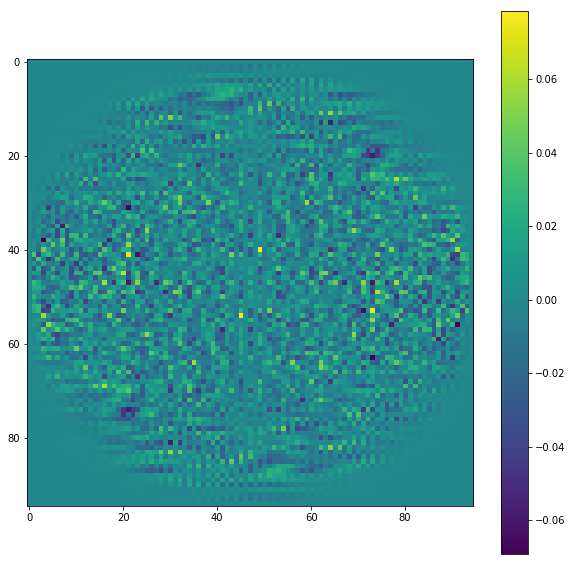

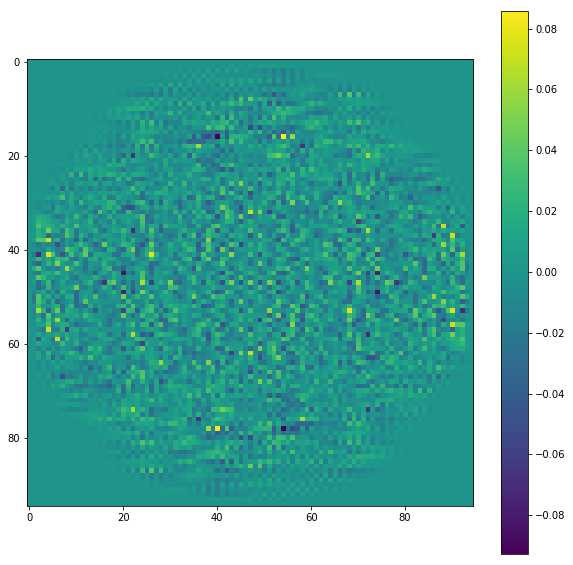

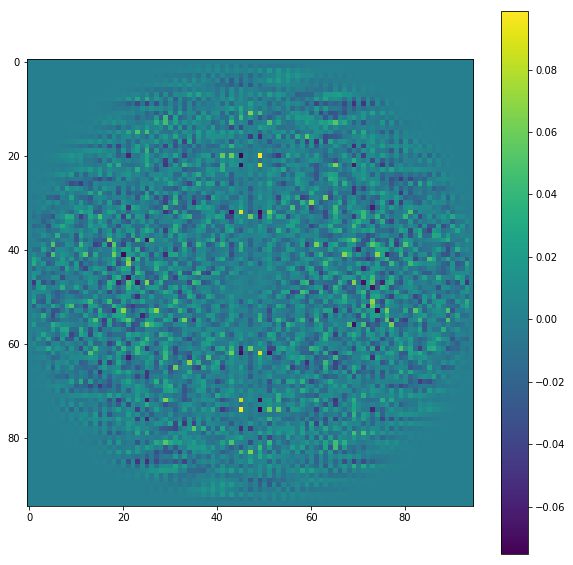

In [23]:
Tmmpmpp_ = sess.run(Tmmpmpp, feed_dict = {s: [s_map], indices: weight_indices})[0]
for output_filter in range(output_filters):
    print(np.min(Tmmpmpp_[:, :, :, output_filter]), np.max(Tmmpmpp_[:, :, :, output_filter]))
    figure(figsize = (10, 10))
    imshow(np.sum(Tmmpmpp_[:, :, :, output_filter].astype(np.float64), axis = 2))
    colorbar()

(-0.06926547801465686+0j) (0.07865683849762978+0j)


/Users/charnock/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """


(-0.09285398162382495+0j) (0.08588120081381656+0j)
(-0.07528889793354586+0j) (0.09886297237312726+0j)


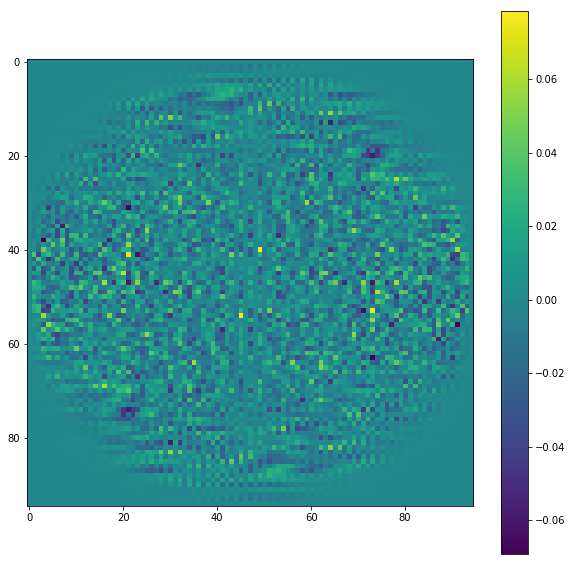

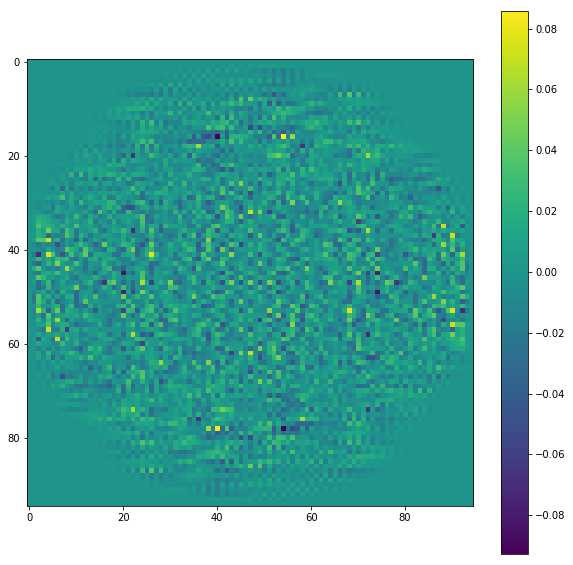

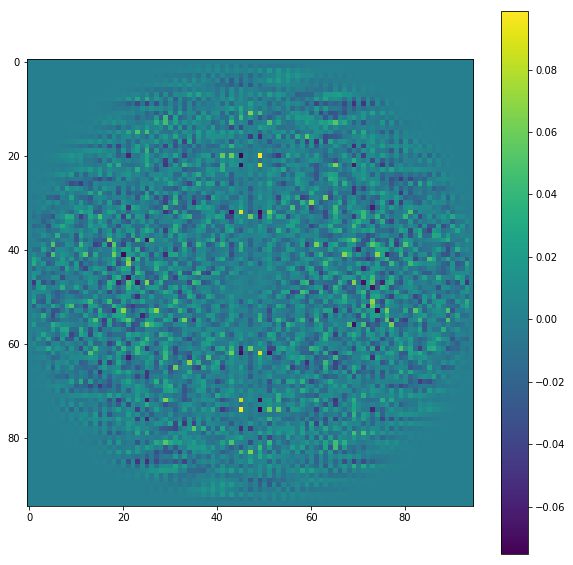

In [24]:
Tmmp_ = sess.run(Tmmp, feed_dict = {s: [s_map], indices: weight_indices})[0]
for output_filter in range(output_filters):
    print(np.min(Tmmp_[:, :, output_filter]), np.max(Tmmp_[:, :, output_filter]))
    figure(figsize = (10, 10))
    imshow(Tmmp_[:, :, output_filter].astype(np.float64))
    colorbar()

(-0.4722482384205484-7.857290777308638e-16j) (0.41721701490491847+6.405378851458143e-09j)
(-0.4268953068806162+2.7564826383854463e-06j) (0.52278273518827+7.189993087150168e-08j)


/Users/charnock/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/healpy/projector.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  img[w] = mpix


(-0.505653380034195-2.3143535460314835e-16j) (0.8901111861321497+7.088545759335982e-09j)


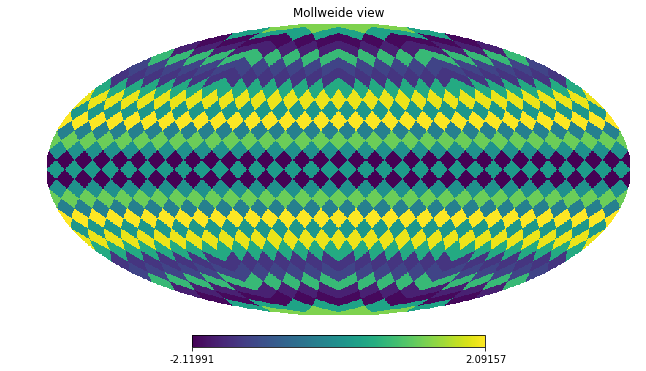

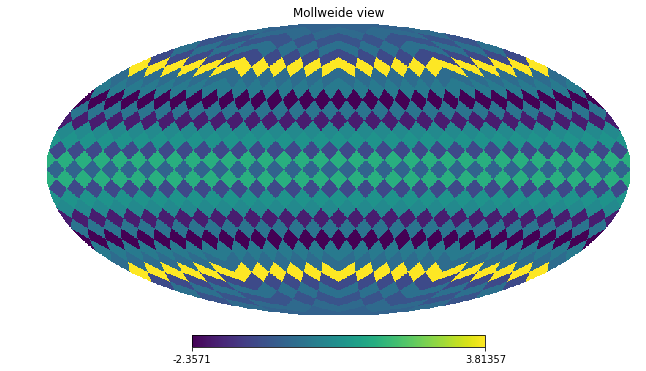

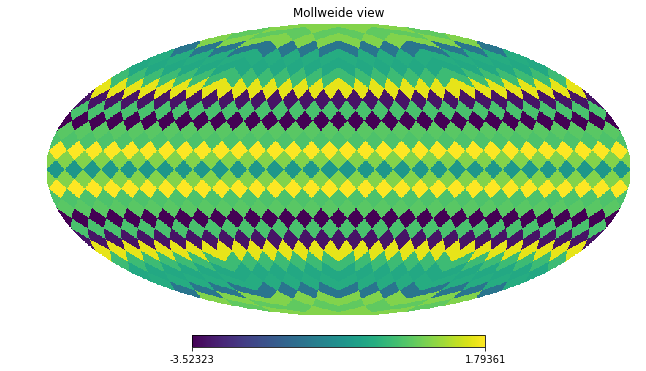

In [26]:
Tm_ = sess.run(Tm, feed_dict = {s: [s_map], indices: weight_indices, ϕ_kernel: ϕ_b, ϕE_kernel: ϕE_b})[0]
for output_filter in range(output_filters):
    print(np.min(Tm_[:, :, output_filter]), np.max(Tm_[:, :, output_filter]))
    hp.mollview(np.sum(Tm_[:, :, output_filter], axis = 1))

(768, 3)
(-4.011105650259956+3.656494061322229e-16j) (4.440560591939631+1.1065812501063307e-05j)


/Users/charnock/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/healpy/projector.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  img[w] = mpix
/Users/charnock/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/healpy/sphtfunc.py:156: ComplexWarning: Casting complex values to real discards the imaginary part
  lmax = lmax, mmax = mmax, gal_cut = gal_cut)


(-4.776782546673706+5.576709606539551e-08j) (4.564443226039834-7.189993047333159e-08j)
(-5.201266387325118-1.2714844844607966e-09j) (4.587096761648065-2.367738087595134e-05j)


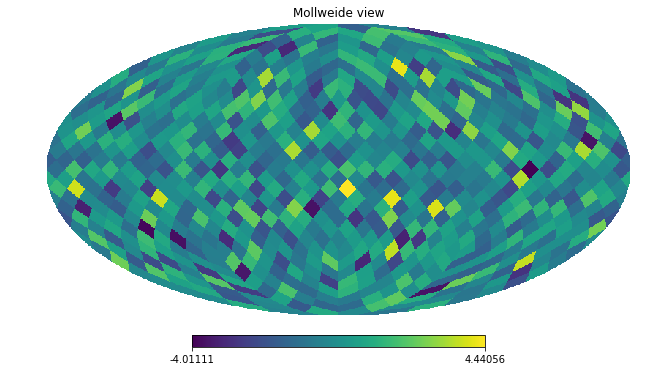

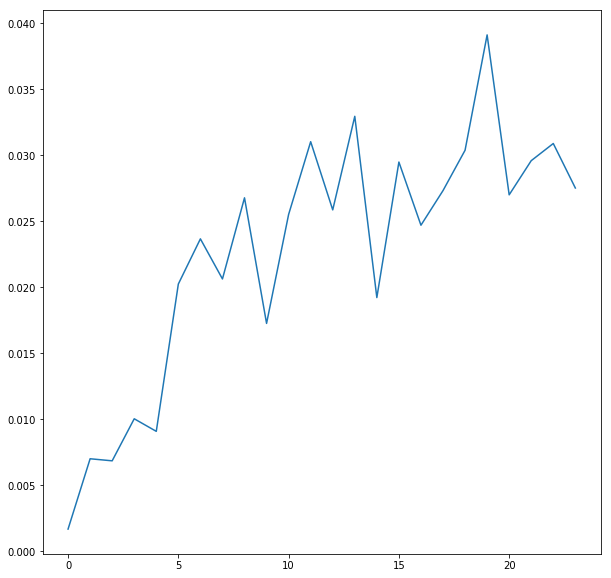

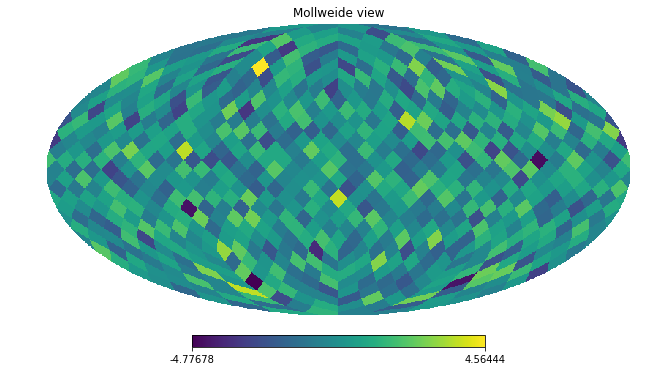

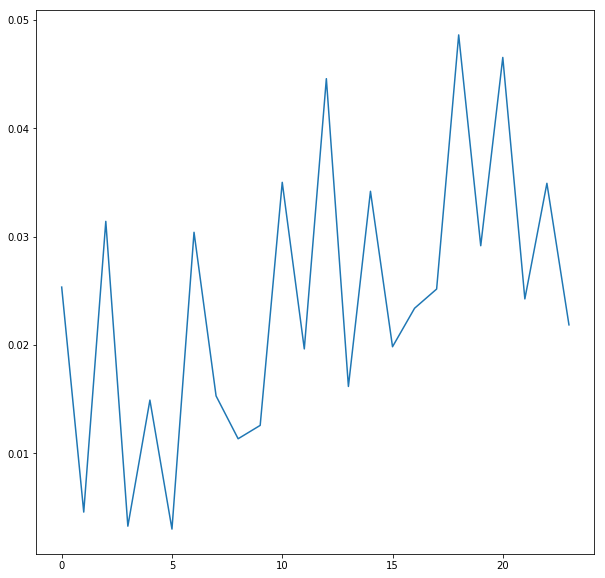

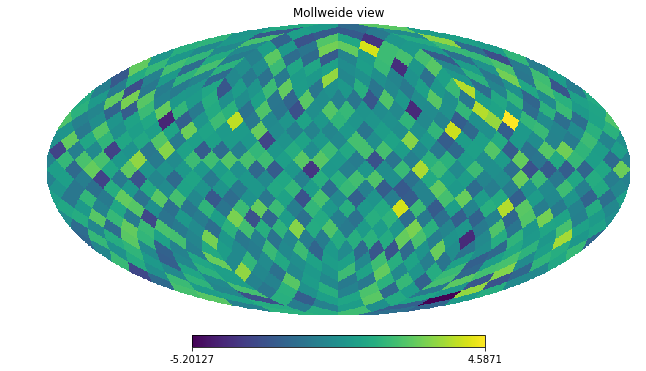

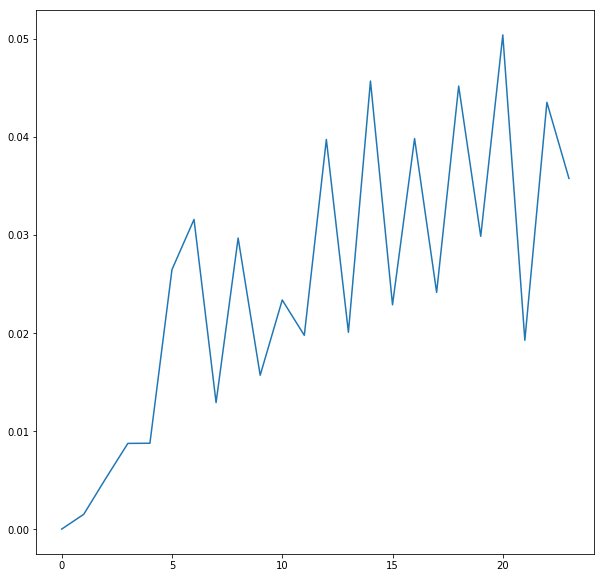

In [29]:
T_ = sess.run(T, feed_dict = {s: [s_map], indices: weight_indices, ϕ_kernel: ϕ_b, ϕE_kernel: ϕE_b})[0]
for output_filter in range(output_filters):
    print(np.min(T_[:, output_filter]), np.max(T_[:, output_filter]))
    hp.mollview(T_[:, output_filter])
    figure(figsize(10, 10))
    plot(hp.anafast(T_[:, output_filter]))